In [73]:
from deLib import droplet_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myImageLib import readdata
from pivLib import piv_data, read_piv
from skimage import io
import os

In [90]:
img_folder = r"D:\DE\06012022\03\raw"
l = readdata(img_folder, "tif")[:10]

In [83]:
di = droplet_image(l)

In [51]:
mask_dir = r"C:\Users\liuzy\Documents\06012022\mask\03.tif"
winsize = 20
overlap = 10
dt = 0.02
save_folder = r"C:\Users\liuzy\Documents\06012022\PIV\03\w{:d}".format(winsize)
di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)

In [43]:
save_folder

'C:\\Users\\liuzy\\Documents\\06012022\\PIV\\03\\w20'

In [52]:
pl = readdata(save_folder, "csv")
pivdata =piv_data(pl, fps=50)
pivdata.mean_velocity().mean()[0]

0.28

In [59]:
pivdata.mean_velocity().mean()

t         0.6800
v_mean    0.5168
dtype: float64

In [70]:
# try varies winsize and overlap
mask_dir = r"C:\Users\liuzy\Documents\06012022\mask\03.tif"
dt = 0.02
for winsize in range(40, 80, 10):
    overlap = winsize // 2
    save_folder = r"C:\Users\liuzy\Documents\06012022\PIV\03\w{:d}".format(winsize)
    di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)
    pl = readdata(save_folder, "csv")
    pivdata =piv_data(pl, fps=50)
    print("winsize: {0:d} | mean velocity: {1:.2f}".format(winsize, pivdata.mean_velocity().mean()[1]))

winsize: 40 | mean velocity: 0.52
winsize: 50 | mean velocity: 0.31
winsize: 60 | mean velocity: 0.23
winsize: 70 | mean velocity: 0.20


In [84]:
# How many frames are sufficient?
mask_dir = r"C:\Users\liuzy\Documents\06012022\mask\03.tif"
save_folder = r"C:\Users\liuzy\Documents\06012022\PIV\03\w40".format(winsize)
winsize = 10
overlap = 5
dt = 0.02
for nframes in range(10, 40, 10):
    l = readdata(img_folder, "tif")[:nframes]
    di = droplet_image(l)
    di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)
    pl = readdata(save_folder, "csv")
    pivdata =piv_data(pl, fps=50)
    print("nframes: {0:d} | mean velocity: {1:.2f}".format(nframes, pivdata.mean_velocity().mean()[1]))

nframes: 10 | mean velocity: 0.80
nframes: 20 | mean velocity: 1.11
nframes: 30 | mean velocity: 1.40


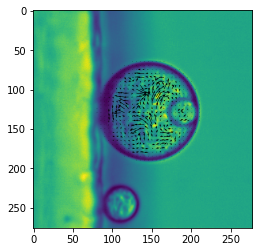

In [92]:
piv_folder = r"C:\Users\liuzy\Documents\06012022\PIV\03\w10"
n = 0
img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(n)))
x, y, u, v = read_piv(os.path.join(piv_folder, "{0:05d}-{1:05d}.csv".format(n, n+1)))
plt.imshow(img)
plt.quiver(x, y, u, v)

Set `winsize=10` for all videos for now.

In [96]:
dates = ["06022022", "06032022"]
winsize = 10
overlap = 5
dt = 0.02
for date in dates:    
    master_folder = r"D:\DE\{}".format(date)
    sfL = next(os.walk(master_folder))[1]
    for sf in sfL:
        img_folder = os.path.join(master_folder, sf, "raw")
        mask_dir = os.path.join(r"C:\Users\liuzy\Documents\{0}\mask\{1}.tif".format(date, sf))
        save_folder = r"C:\Users\liuzy\Documents\{0}\PIV\{1}".format(date, sf)
        l = readdata(img_folder, "tif")[:50]
        di = droplet_image(l)
        di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)
        pl = readdata(save_folder, "csv")
        pivdata = piv_data(pl, fps=50)
        print("winsize: {0:d} | mean velocity: {1:.2f}".format(winsize, pivdata.mean_velocity().mean()[1]))

winsize: 10 | mean velocity: 6.17
winsize: 10 | mean velocity: 2.59
winsize: 10 | mean velocity: 3.51
winsize: 10 | mean velocity: 6.08
winsize: 10 | mean velocity: 4.18
winsize: 10 | mean velocity: 4.59
winsize: 10 | mean velocity: 5.90
winsize: 10 | mean velocity: 2.63
winsize: 10 | mean velocity: 4.29
winsize: 10 | mean velocity: 2.97
winsize: 10 | mean velocity: 1.69


C:\Users\liuzy\Documents\Github\Python\mylib\openpiv\pyprocess.py:272: RuntimeWarning: divide by zero encountered in log
  subp_peak_position = (peak1_i + ((log(cl) - log(cr)) / (2 * log(cl) - 4 * log(c) + 2 * log(cr))),
C:\Users\liuzy\Documents\Github\Python\mylib\openpiv\pyprocess.py:272: RuntimeWarning: invalid value encountered in double_scalars
  subp_peak_position = (peak1_i + ((log(cl) - log(cr)) / (2 * log(cl) - 4 * log(c) + 2 * log(cr))),
C:\Users\liuzy\Documents\Github\Python\mylib\openpiv\pyprocess.py:273: RuntimeWarning: divide by zero encountered in log
  peak1_j + ((log(cd) - log(cu)) / (2 * log(cd) - 4 * log(c) + 2 * log(cu))))
C:\Users\liuzy\Documents\Github\Python\mylib\openpiv\pyprocess.py:273: RuntimeWarning: invalid value encountered in double_scalars
  peak1_j + ((log(cd) - log(cu)) / (2 * log(cd) - 4 * log(c) + 2 * log(cu))))


winsize: 10 | mean velocity: 1.32
winsize: 10 | mean velocity: 2.88


In [100]:
dates = ["06012022"]
for date in dates:
    master_folder = r"D:\DE\{}".format(date)
    sfL = next(os.walk(master_folder))[1]
    for sf in sfL:
        piv_folder = r"C:\Users\liuzy\Documents\{0}\PIV\{1}".format(date, sf)
        pl = readdata(piv_folder, "csv")
        pivdata = piv_data(pl, fps=50)
        print("{0}-{1} | mean velocity: {2:.2f} um/s".format(date, sf, pivdata.mean_velocity().mean()[1]))

06012022-00 | mean velocity: 1.92 um/s
06012022-01 | mean velocity: 2.55 um/s
06012022-02 | mean velocity: 2.49 um/s
06012022-03 | mean velocity: 1.05 um/s
06012022-04 | mean velocity: 3.14 um/s
06012022-05 | mean velocity: 4.78 um/s
06012022-06 | mean velocity: 2.95 um/s
06012022-07 | mean velocity: 5.14 um/s
06012022-08 | mean velocity: 6.91 um/s
06012022-09 | mean velocity: 1.95 um/s


In [103]:
img_folder = r"C:\Users\liuzy\Documents\cristian-piv\exp3_od100_60fps_60x_1_C001H001S0002"
l = readdata(img_folder, "tif")[:10]
di = droplet_image(l)

In [130]:
mask_dir = r"C:\Users\liuzy\Documents\cristian-piv\mask.tif"
winsize = 40
overlap = winsize // 2
dt = 1 / 60
for winsize in range(45, 100, 5):
    save_folder = r"C:\Users\liuzy\Documents\cristian-piv\piv\w{:d}".format(winsize)
    di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)

In [156]:
piv_folder = r"C:\Users\liuzy\Documents\cristian-piv\piv\w15"
pl = readdata(piv_folder, "csv")
piv_dir = pl.Dir[0]
x, y, u, v = read_piv(piv_dir)
image_name = os.path.split(piv_dir)[1].split("-")[0]

(370.0, 130.0)

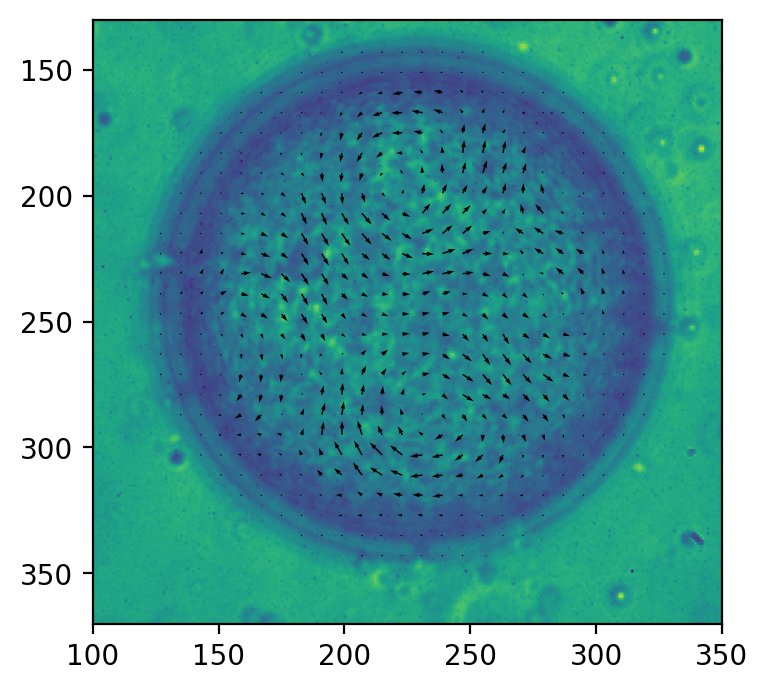

In [157]:
img = io.imread(os.path.join(img_folder, "{}.tif".format(image_name)))
plt.figure(dpi=200)
plt.imshow(img)
plt.quiver(x, y, u, v)
plt.xlim([100, 350])
plt.ylim([370, 130])

10 | 136.1
15 | 99.0
20 | 85.1
25 | 77.5
30 | 66.3
35 | 51.4
40 | 44.0
45 | 29.3


(-40.0, 40.0)

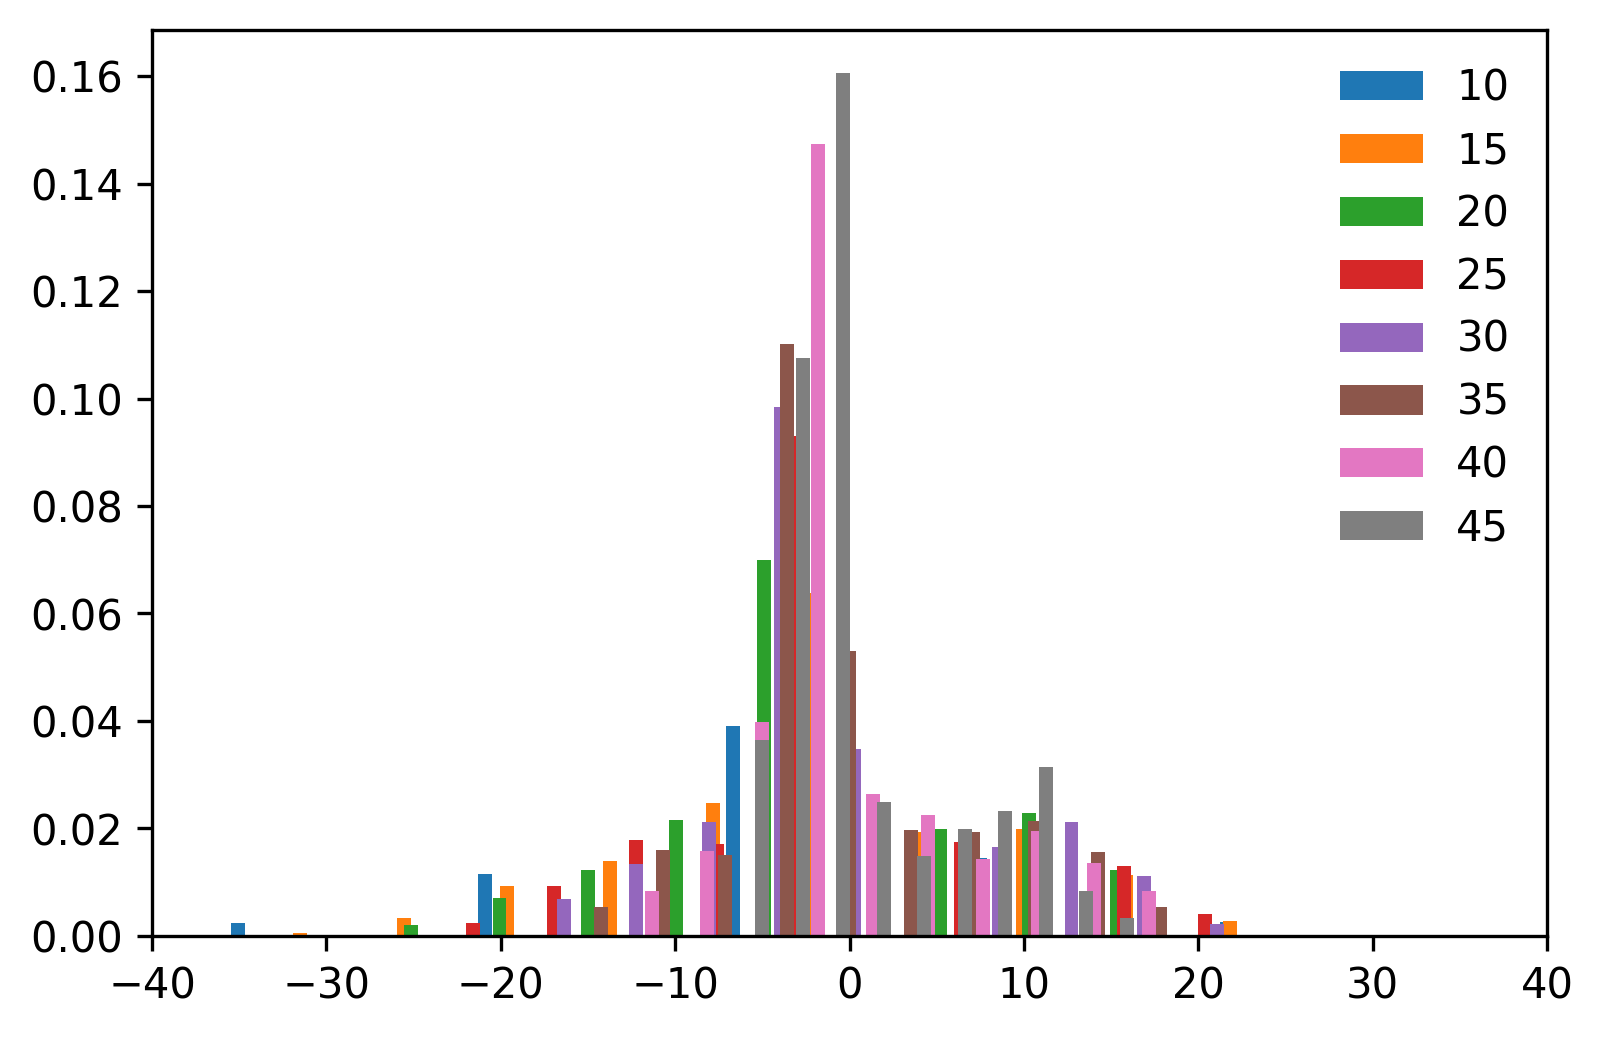

In [142]:
plt.figure(dpi=300)
for w in range(10, 50, 5):
    piv_folder = r"C:\Users\liuzy\Documents\cristian-piv\piv\w{:d}".format(w)
    pl = readdata(piv_folder, "csv")
    u_list = []
    v_list = []
    for num, i in pl.iterrows():
        x, y, u, v = read_piv(i.Dir)
        u_list.append(u)
        v_list.append(v)
    ua = np.array(u_list)
    va = np.array(v_list)
    hist, bin_edges = np.histogram(ua, range=(np.nanmin(ua), np.nanmax(ua)), density=True)
    plt.bar(bin_edges[:-1], hist, label=w)
    print("{0:d} | {1:.1f}".format(w, np.nanmean(ua**2)))
plt.legend(frameon=False)
plt.xlim([-40, 40])

In [158]:
img_folder = r"C:\Users\liuzy\Documents\cristian-piv\exp3_od100_60fps_60x_1_C001H001S0002"
l = readdata(img_folder, "tif")
di = droplet_image(l)
mask_dir = r"C:\Users\liuzy\Documents\cristian-piv\mask.tif"
winsize = 15
overlap = winsize // 2
dt = 1 / 60
save_folder = r"C:\Users\liuzy\Documents\cristian-piv\piv"
di.fixed_mask_piv(save_folder, winsize, overlap, dt, mask_dir)